In [1]:
# -*- coding:utf8 -*-
import re
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from mydatools.plot import plot_grid_search_result

% matplotlib inline

In [2]:
train_df = pd.read_json('./data/input/train.json')
test_df = pd.read_json('./data/input/test.json')

input_df = pd.concat([train_df, test_df], keys=['train', 'test'])
input_df.head()

bathrooms  bedrooms                       building_id  \
train 10            1.5         3  53a5b119ba8f7b61d4e010512e0dfc85   
      10000         1.0         2  c5c8a357cba207596b04d1afd1e4f130   
      100004        1.0         1  c3ba40552e2120b0acfc3cb5730bb2aa   
      100007        1.0         1  28d9ad350afeaab8027513a3e52ac8d5   
      100013        1.0         4                                 0   

                          created  \
train 10      2016-06-24 07:54:24   
      10000   2016-06-12 12:19:27   
      100004  2016-04-17 03:26:41   
      100007  2016-04-18 02:22:02   
      100013  2016-04-28 01:32:41   

                                                    description  \
train 10      A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...   
      10000                                                       
      100004  Top Top West Village location, beautiful Pre-w...   
      100007  Building Amenities - Garage - Garden - fitness...   
      100013  Beautifully renovated 3 bedroom flex 4 bedroom...   

                  display_address  \
train 10      Metropolitan Avenue   
      10000       Columbus Avenue   
      100004          W 13 Street   
      100007     East 49th Street   
      100013    West 143rd Street   

                                                       features  \
train 10                                                     []   
      10000   [Doorman, Elevator, Fitness Center, Cats Allow...   
      100004  [Laundry In Building, Dishwasher, Hardwood Flo...   
      100007                          [Hardwood Floors, No Fee]   
      100013                                          [Pre-War]   

             interest_level  latitude  listing_id  longitude  \
train 10             medium   40.7145     7211212   -73.9425   
      10000             low   40.7947     7150865   -73.9667   
      100004           high   40.7388     6887163   -74.0018   
      100007            low   40.7539     6888711   -73.9677   
      100013            low   40.8241     6934781   -73.9493   

                                    manager_id  \
train 10      5ba989232d0489da1b5f2c45f6688adc   
      10000   7533621a882f71e25173b27e3139d83d   
      100004  d9039c43983f6e564b1482b273bd7b01   
      100007  1067e078446a7897d2da493d2f741316   
      100013  98e13ad4b495b9613cef886d79a6291f   

                                                         photos  price  \
train 10      [https://photos.renthop.com/2/7211212_1ed4542e...   3000   
      10000   [https://photos.renthop.com/2/7150865_be3306c5...   5465   
      100004  [https://photos.renthop.com/2/6887163_de85c427...   2850   
      100007  [https://photos.renthop.com/2/6888711_6e660cee...   3275   
      100013  [https://photos.renthop.com/2/6934781_1fa4b41a...   3350   

                       street_address  
train 10      792 Metropolitan Avenue  
      10000       808 Columbus Avenue  
      100004          241 W 13 Street  
      100007     333 East 49th Street  
      100013    500 West 143rd Street

In [3]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 124011 entries, (train, 10) to (test, 99999)
Data columns (total 15 columns):
bathrooms          124011 non-null float64
bedrooms           124011 non-null int64
building_id        124011 non-null object
created            124011 non-null object
description        124011 non-null object
display_address    124011 non-null object
features           124011 non-null object
interest_level     49352 non-null object
latitude           124011 non-null float64
listing_id         124011 non-null int64
longitude          124011 non-null float64
manager_id         124011 non-null object
photos             124011 non-null object
price              124011 non-null int64
street_address     124011 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 15.7+ MB


## 特征工程

In [4]:
full_df = input_df.copy()

In [5]:
feature_columns = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price']
id_column = 'listing_id'
label_column = 'interest_level'

In [82]:
def add_features(feats):
    if type(feats) != list:
        feats = [feats]
    for feat in feats:
        if feat not in feature_columns:
            feature_columns.append(feat)

* description, features and photos number

In [6]:
full_df['description_num'] = full_df['description'].apply(lambda x: len(x.split(" ")))
full_df['description_len'] = full_df['description'].apply(len)
full_df['features_num'] = full_df['features'].apply(len)
full_df['photos_num'] = full_df['photos'].apply(len)
feature_columns += ['description_num', 'features_num', 'photos_num']

* created time

In [7]:
full_df['created'] = pd.to_datetime(full_df['created'])

In [8]:
full_df['created_year'] = full_df['created'].dt.year
full_df['created_month'] = full_df['created'].dt.month
full_df['created_day'] = full_df['created'].dt.day
full_df['created_hour'] = full_df['created'].dt.hour
full_df['created_dayofweek'] = full_df['created'].dt.dayofweek
full_df['created_week'] = full_df['created'].dt.week
full_df['created_is_weekend'] = np.where(full_df['created_dayofweek'].isin([5,6]), 1, 0)
feature_columns += ['created_year', 'created_month', 'created_day', 'created_hour', 'created_dayofweek', 'created_week', 'created_is_weekend']

* bathroom, bedroom

In [9]:
full_df['price_per_bathroom'] = full_df['price'] / (full_df['bathrooms'] + 1)
full_df['price_per_bedroom'] = full_df['price'] / (full_df['bedrooms'] + 1)
full_df['bedroom_per_bathroom'] = (full_df['bedrooms'] + 1) / (full_df['bathrooms'] + 1)
# 发现越高的interest_level都没有.5的bathroom
full_df['has_half_bathroom'] = np.where(full_df['bathrooms'] != full_df['bathrooms'].round(0), 1, 0)
full_df['rooms_num'] = full_df['bathrooms'] + full_df['bedrooms']
feature_columns += ['price_per_bathroom', 'price_per_bedroom', 'bedroom_per_bathroom', 'rooms_num']

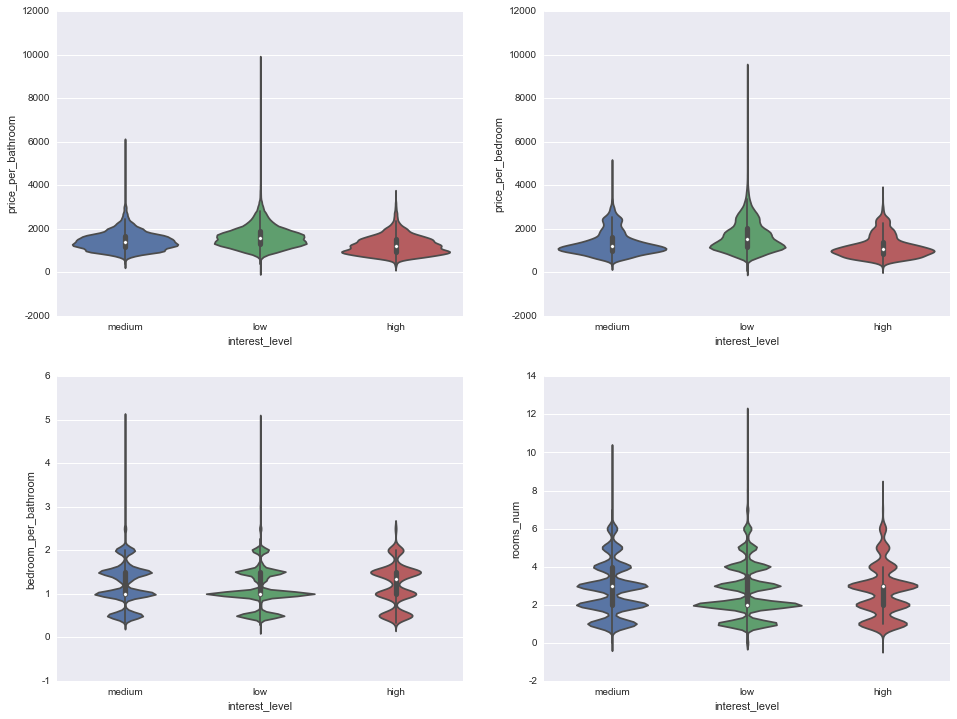

In [10]:
fig, ax = plt.subplots(2,2, figsize=(16,12))
display_df = full_df[full_df['price'] < 10000] # 去除异常数据
sns.violinplot(x='interest_level', y='price_per_bathroom', data=display_df, ax=ax[0][0])
sns.violinplot(x='interest_level', y='price_per_bedroom', data=display_df, ax=ax[0][1])
sns.violinplot(x='interest_level', y='bedroom_per_bathroom', data=display_df, ax=ax[1][0])
sns.violinplot(x='interest_level', y='rooms_num', data=display_df, ax=ax[1][1])

* features

In [11]:
# 对feature的word进行处理
stemmer = PorterStemmer()
def features_word_transform(s):
    s = s.strip().lower() 
    s = s.replace('-','_').replace(' ','_') # 去掉-和空格
    # 将word进行stem
    s = '_'.join([stemmer.stem(word) for word in s.split('_')])
    return s

# 将list修改为空格分隔的str
full_df['features_str'] = full_df['features'].apply(lambda x: " ".join([features_word_transform(i) for i in x]))

In [12]:
# 对feature的word进行TfidfVectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', max_features=50)
tfidf_vec.fit(full_df.loc['train']['features_str'])
tfidf_df = pd.DataFrame(tfidf_vec.transform(full_df['features_str']).toarray(), index=full_df.index)

In [13]:
# # 原本是想用svd对word进行降维处理，但电脑内存不足
# svd = TruncatedSVD(n_components=25)
# svd.fit(tfidf_df.loc['train'].iloc[:10000])

In [14]:
# 将features出现的word加入到特征
add_feature_columns = ['features_word_'+c for c in tfidf_vec.get_feature_names()]
add_full_df = pd.DataFrame(tfidf_vec.transform(full_df['features_str']).toarray(), columns=add_feature_columns, index=full_df.index)
full_df = full_df.join(add_full_df)
feature_columns += add_feature_columns

* description

In [15]:
# 取出description中的词
stemmer = PorterStemmer()
def description_transform(s):
    # 去掉html格式
    s = BeautifulSoup(s, 'lxml').get_text(' ')
    # 取出word
    s = s.lower()
    regex = re.compile('[^a-z]')
    s = regex.sub(' ', s)
    # 进行stem
    s = ' '.join([stemmer.stem(w) for w in s.split(' ')])
    return s

full_df['description_new'] = full_df['description'].apply(description_transform)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You shouldprobably open this file and pass the filehandle intoBeautiful Soup.
  'Beautiful Soup.' % markup)


In [16]:
# 对feature的word进行TfidfVectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', max_features=50)
tfidf_vec.fit(full_df.loc['train']['description'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [17]:
# 将features出现的word加入到特征
add_feature_columns = ['description_word_'+w for w in tfidf_vec.get_feature_names()]
add_full_df = pd.DataFrame(tfidf_vec.transform(full_df['description']).toarray(), columns=add_feature_columns, index=full_df.index)
full_df = full_df.join(add_full_df)
feature_columns += add_feature_columns

* listing id

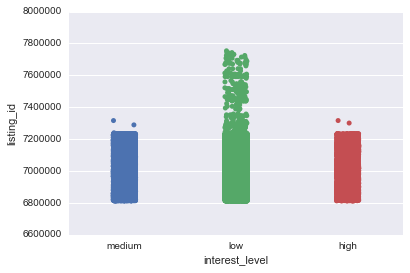

In [18]:
# 发现low的listing_id特别高，所以这是一个有用的特征
# 但是没理解他的现实作用
sns.stripplot(full_df['interest_level'], full_df['listing_id'], jitter=True)

In [19]:
full_df['listing_id'] = full_df['listing_id'] - full_df['listing_id'].min()

* 对非数字特征进行labelencode，并获取计数和排序

In [20]:
feature_to_deal = ["display_address", "manager_id", "building_id", "street_address"]
for f in feature_to_deal:
    # labelencode
    lbf = f + '_labelencode'
    lbl = preprocessing.LabelEncoder()
    lbl.fit(full_df[f].values)
    full_df[lbf] = lbl.transform(full_df[f].values)
    feature_columns.append(lbf)
    
    # rank & count
    countf = f + '_count'
    rankf = f + '_rank'
    ct = Counter(full_df[f]) # 统计数量
    ct_df = pd.DataFrame({f: list(ct.keys()), countf: list(ct.values())}, index=ct.keys()) 
    ct_df.sort_values(by=[countf, f], inplace=True) # 按count, feat_id排序
    ct_df[rankf] = np.arange(ct_df.shape[0]) # 生成rank
    # 插入full_df中
    full_df.drop([countf, rankf], axis=1, errors='ignore', inplace=True)
    full_df = full_df.join(ct_df[[countf, rankf]], on=f)
    feature_columns += [countf, rankf]

* 计算每个manager_id对应count，再计算low/medium/high在count的占比，增加三列

思想：不同manager_id可能带来的interest_level有差别

In [23]:
def get_manager_id_to_interest_level(target_df):
    temp_df = target_df.groupby(['interest_level', 'manager_id'])[['listing_id']].count()
    temp_df = temp_df.reset_index().pivot_table('listing_id', 'manager_id', 'interest_level').fillna(0)
    temp_df = temp_df.div(temp_df.sum(axis=1), axis=0)
    temp_df = temp_df.rename(columns={x: 'manager_id_%s_ratio'%x for x in ['high', 'low', 'medium']})
    return temp_df

In [24]:
add_feature_columns = ['manager_id_%s_ratio'%x for x in ['high', 'low', 'medium']]
for c in add_feature_columns:
    full_df[c] = 0

In [25]:
# 生成训练数据的manager_id_low_ratio...
kf = model_selection.KFold(n_splits=5, shuffle=True)
for tra_index, val_index in kf.split(full_df.loc['train']):
    tra_df = full_df.loc['train'].iloc[tra_index]
    val_df = full_df.loc['train'].iloc[val_index]
    temp_df = get_manager_id_to_interest_level(tra_df)
    val_df = val_df[['manager_id']].join(temp_df, on='manager_id')
    full_df.ix[val_index, add_feature_columns] = val_df[add_feature_columns].values

In [26]:
# 生成测试数据的manager_id_low_ratio...
temp_df = get_manager_id_to_interest_level(full_df.loc['train'])
add_df = full_df.loc['test'][['manager_id']].join(temp_df, on='manager_id')
full_df.loc['test', add_feature_columns] = add_df[add_feature_columns].values

In [27]:
full_df[add_feature_columns] = full_df[add_feature_columns].fillna(0)
feature_columns += add_feature_columns

* 房间数对应的price中位数，距离中位数的距离比例

思路：不同房间数的price不同，需要分别对待

In [85]:
def add_price_to_median_ratio(feat):
    median_df = full_df.groupby(feat)[['price']].median()
    add_feat = '%s_price_to_median_ratio'%feat
    full_df[add_feat] = full_df[[feat]].join(median_df, on=feat)['price']
    full_df[add_feat] = (full_df['price'] - full_df[add_feat]) / full_df[add_feat]
    add_features(add_feat)
    
add_price_to_median_ratio('bedrooms')

* 特征工程最终结果

In [88]:
full_df.head()

bathrooms  bedrooms                       building_id  \
train 10            1.5         3  53a5b119ba8f7b61d4e010512e0dfc85   
      10000         1.0         2  c5c8a357cba207596b04d1afd1e4f130   
      100004        1.0         1  c3ba40552e2120b0acfc3cb5730bb2aa   
      100007        1.0         1  28d9ad350afeaab8027513a3e52ac8d5   
      100013        1.0         4                                 0   

                         created  \
train 10     2016-06-24 07:54:24   
      10000  2016-06-12 12:19:27   
      100004 2016-04-17 03:26:41   
      100007 2016-04-18 02:22:02   
      100013 2016-04-28 01:32:41   

                                                    description  \
train 10      A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...   
      10000                                                       
      100004  Top Top West Village location, beautiful Pre-w...   
      100007  Building Amenities - Garage - Garden - fitness...   
      100013  Beautifully renovated 3 bedroom flex 4 bedroom...   

                  display_address  \
train 10      Metropolitan Avenue   
      10000       Columbus Avenue   
      100004          W 13 Street   
      100007     East 49th Street   
      100013    West 143rd Street   

                                                       features  \
train 10                                                     []   
      10000   [Doorman, Elevator, Fitness Center, Cats Allow...   
      100004  [Laundry In Building, Dishwasher, Hardwood Flo...   
      100007                          [Hardwood Floors, No Fee]   
      100013                                          [Pre-War]   

             interest_level  latitude  listing_id  \
train 10             medium   40.7145      399255   
      10000             low   40.7947      338908   
      100004           high   40.7388       75206   
      100007            low   40.7539       76754   
      100013            low   40.8241      122824   

                           ...                building_id_labelencode  \
train 10                   ...                                   3797   
      10000                ...                                   8986   
      100004               ...                                   8889   
      100007               ...                                   1848   
      100013               ...                                      0   

             building_id_count building_id_rank  street_address_labelencode  \
train 10                     5             8411                       23484   
      10000                 51            11244                       23680   
      100004               131            11542                        9827   
      100007               236            11592                       14237   
      100013             20664            11634                       19227   

             street_address_count  street_address_rank  manager_id_high_ratio  \
train 10                        5                21365               0.000000   
      10000                    46                25413               0.000000   
      100004                   66                25569               0.048077   
      100007                  130                25715               0.070513   
      100013                    3                18948               0.000000   

              manager_id_low_ratio  manager_id_medium_ratio  \
train 10                  0.794872                 0.205128   
      10000               0.985507                 0.014493   
      100004              0.538462                 0.413462   
      100007              0.788462                 0.141026   
      100013              1.000000                 0.000000   

              bedrooms_price_to_median_ratio  
train 10                           -0.333333  
      10000                         0.631343  
      100004                       -0.017241  
      100007                        0.129310  
      1

## 数据预处理

In [89]:
classes_map = {'high': 0, 'medium': 1, 'low': 2}

In [90]:
X = full_df.loc['train'][feature_columns].values
y = full_df.loc['train'][label_column].map(classes_map).values

X_train = X
y_train = y

X_pred = full_df.loc['test'][feature_columns].values

In [91]:
scoring = 'neg_log_loss'

## Random Forest

In [92]:
# # 对树的数量、最大深度进行调参
# search_paras = {'n_estimators': [200,500,1000], 'max_depth': [10,20,30]}
# rf_gs = GridSearchCV(RandomForestClassifier(), search_paras, scoring=scoring)
# rf_gs.fit(X_train, y_train)

In [93]:
# plot_grid_search_result(rf_gs)

## XGBoost

In [94]:
import xgboost as xgb

In [95]:
xg_train = xgb.DMatrix(X_train, y_train)
xg_pred = xgb.DMatrix(X_pred)

In [96]:
# class NewXGBClassifier(xgb.XGBClassifier):
#     def __init__(self, max_depth=3, learning_rate=0.1, n_estimators=100,
#                  silent=True, objective="reg:linear",
#                  nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0,
#                  subsample=1, colsample_bytree=1, colsample_bylevel=1,
#                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#                  base_score=0.5, seed=0, missing=None, eval_metric=None):
        
#         self.max_depth = max_depth
#         self.learning_rate = learning_rate
#         self.n_estimators = n_estimators
#         self.silent = silent
#         self.objective = objective

#         self.nthread = nthread
#         self.gamma = gamma
#         self.min_child_weight = min_child_weight
#         self.max_delta_step = max_delta_step
#         self.subsample = subsample
#         self.colsample_bytree = colsample_bytree
#         self.colsample_bylevel = colsample_bylevel
#         self.reg_alpha = reg_alpha
#         self.reg_lambda = reg_lambda
#         self.scale_pos_weight = scale_pos_weight

#         self.base_score = base_score
#         self.seed = seed
#         self.missing = missing if missing is not None else np.nan
#         self._Booster = None
        
#         self.eval_metric = eval_metric
        
#     def fit(self, X, y):
#         return super(NewXGBClassifier, self).fit(X, y, eval_metric=self.eval_metric)


In [97]:
bst_paras = {
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': 3,
#     'n_estimators': 1000,
    'eta': 0.1,
    'colsample_bytree': 0.7,
    'subsample': 0.7,
    'max_depth': 6,
    'missing': 0,
    'seed': 1,
}
num_boost_round = 1000

In [98]:
# best_model = None
# best_score = 1
# kf = model_selection.KFold(n_splits=10, shuffle=True)
# for tra_index, val_index in kf.split(X_train):
#     X_tra, X_val = X_train[tra_index], X_train[val_index]
#     y_tra, y_val = y_train[tra_index], y_train[val_index]
#     xg_tra = xgb.DMatrix(X_tra, label=y_tra)
#     xg_val = xgb.DMatrix(X_val, label=y_val)
#     watchlist = [(xg_tra, 'train'), (xg_val, 'test')]
#     model = xgb.train(bst_paras, xg_tra, num_boost_round, watchlist, early_stopping_rounds=10, verbose_eval=False)
# #     model = xgb.train(bst_paras, xg_tra, num_boost_round, watchlist)
#     score = metrics.log_loss(y_val, model.predict(xg_val))
#     if score <= best_score:
#         best_model = model
#     print(score)
# bst = best_model

In [99]:
xgb_cv_res = xgb.cv(bst_paras, xg_train, num_boost_round, nfold=5, stratified=True, early_stopping_rounds=20, verbose_eval=25)
best_round = np.argmin(xgb_cv_res['test-mlogloss-mean'])
print('best_model:', xgb_cv_res.iloc[best_round])
bst = xgb.train(bst_paras, xg_train, best_round)
print('train_loss:', metrics.log_loss(y_train, bst.predict(xg_train)))

[0]	train-mlogloss:1.0311+0.00018801	test-mlogloss:1.03254+0.000201913
[25]	train-mlogloss:0.570516+0.000761385	test-mlogloss:0.602563+0.00128296
[50]	train-mlogloss:0.505248+0.000877581	test-mlogloss:0.562208+0.00225435
[75]	train-mlogloss:0.470407+0.00125024	test-mlogloss:0.549768+0.00235877
[100]	train-mlogloss:0.44353+0.00109973	test-mlogloss:0.543992+0.00240362
[125]	train-mlogloss:0.421216+0.000877987	test-mlogloss:0.541097+0.00243011
[150]	train-mlogloss:0.402693+0.00117267	test-mlogloss:0.539367+0.00261187
[175]	train-mlogloss:0.385849+0.00135562	test-mlogloss:0.53845+0.00234903
[200]	train-mlogloss:0.369788+0.00144897	test-mlogloss:0.538048+0.00240018
[225]	train-mlogloss:0.354743+0.00119622	test-mlogloss:0.537681+0.0025744
[250]	train-mlogloss:0.340913+0.000869956	test-mlogloss:0.537752+0.00272944
best_model: test-mlogloss-mean     0.537665
test-mlogloss-std      0.002689
train-mlogloss-mean    0.346805
train-mlogloss-std     0.000973
Name: 239, dtype: float64
train_loss: 0.3

In [100]:
xgb_cv_res.iloc[best_round][['train-mlogloss-mean', 'test-mlogloss-mean']]

train-mlogloss-mean    0.346805
test-mlogloss-mean     0.537665
Name: 239, dtype: float64

## learning curve

In [101]:
def xgb_cv(bst_paras, x_tra, num_boost_round):
    xgb_cv_res = xgb.cv(bst_paras, x_tra, num_boost_round, nfold=5, stratified=True, early_stopping_rounds=20, verbose_eval=25)
    best_round = np.argmin(xgb_cv_res['test-mlogloss-mean'])
    best_ser = xgb_cv_res.iloc[best_round]
    return best_ser['train-mlogloss-mean'], best_ser['test-mlogloss-mean']

In [102]:
# learning curve
def get_learning_curve(X_train, y_train, train_size_list):
    train_score_list = []
    test_score_list = []
    for tra_size in train_size_list:
        print('train size:', tra_size)
        X_tra = X_train[:tra_size]
        y_tra = y_train[:tra_size]
        xg_tra = xgb.DMatrix(X_tra, y_tra)
        train_score, test_score = xgb_cv(bst_paras, xg_tra, 1000)
        print(train_score, test_score)
        train_score_list.append(train_score)
        test_score_list.append(test_score)
    return train_score_list, test_score_list

In [103]:
# train_size_list = (np.linspace(0.1, 1, 10) * len(X_train)).astype(np.int)
# train_score_list, test_score_list = get_learning_curve(X_train, y_train, train_size_list)
# plt.plot(train_size_list, train_score_list)
# plt.plot(train_size_list, test_score_list)

## 预测

In [104]:
# 选择模型 并预测
# model = bst_gs.best_estimator_
# pred_proba = model.predict_proba(X_pred)

model = bst
pred_proba = model.predict(xgb.DMatrix(X_pred))

# 结果df
res_df = pd.DataFrame({
    'listing_id': input_df.loc['test']['listing_id'],
    'high': pred_proba[:, 0],
    'medium': pred_proba[:, 1],
    'low': pred_proba[:, 2],
})
res_df = res_df[['listing_id', 'high', 'medium', 'low']]

# save as csv
res_df.to_csv('./data/output/result.csv', index=False)

# zip
# import zipfile
# with zipfile.ZipFile('./data/output/result.zip', 'w') as f:
#     f.write('./data/output/result.csv')

In [105]:
# pd.Series(model.feature_importances_, index=feature_columns).sort_values()